### Import Library

In [1]:
import os
import pandas as pd
import torch
from argparse import Namespace
from torch.utils.data import DataLoader

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from config.config_KR import *
from model.dfm_model import * 
from model.var_model import *
from model.kalman_filter import *
from utils.deep_learning import *
from utils.data_loader import *
from utils.visualization import *
from model.MLPpatchLatent import Model

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Load Data

In [2]:
target_df = load_target_data(TARGET_PATH)
target_df_train = target_df[target_df.index < TEST_DATE]
target_df_test  = target_df[target_df.index >= TEST_DATE]

### Dynamic Factor Model (DFM)

In [3]:
dfm_results = run_dfm(target_df_train, target_df_test, REFERENCE_DATE)
# train phase 
optimal_factors = dfm_results["optimal_factors"]
shared_component_final_train = dfm_results["shared_component_final_train"]
loadings     = dfm_results["loadings"]
scale_factor = dfm_results["scale_factor"]
offset       = dfm_results["offset"]

combined_array = dfm_results["combined_shared_component"]

factor_column_list = []
for i in range(optimal_factors):
    factor_column_list.append("factor"+str(i+1))

factor_df = pd.DataFrame(combined_array, columns=factor_column_list, index=target_df.index)


Number of common factors 1: AIC = 7497.23
Number of common factors 2: AIC = 7444.15
Number of common factors 3: AIC = 7786.24
Number of common factors 4: AIC = 8267.28
Number of common factors 5: AIC = 8368.87

Optimal number of common factors: 2
Optimization terminated successfully.
         Current function value: 18.458637
         Iterations: 17
         Function evaluations: 9882


In [4]:
df = load_feature_data(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)
df = pd.concat([df, factor_df], axis=1)
df = df.dropna()

### Vector Autoregression (VAR)

{'call_rate': 8, 'bond_3yr': 23, 'loan_rate_avg': 23, 'KOSPI': 9, 'NASDAQ': 9, 'M2_KR': 12, 'M2_US': 12, 'broad_liquidity': 19, 'CPI_growth': 23, 'USD_KRW_rate': 8, 'GDP_growth': 21, 'res_start': 2, 'res_permit': 4, 'factor2': 12}


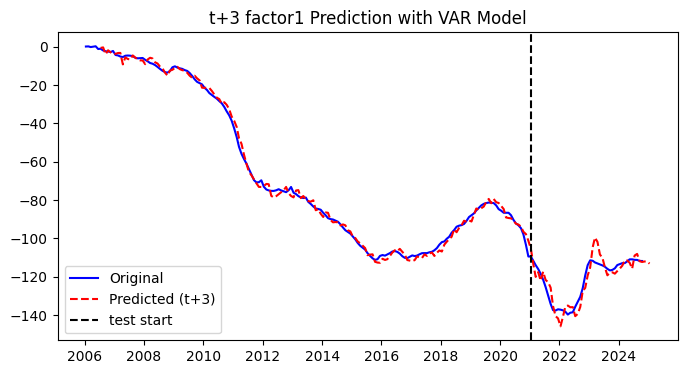

{'call_rate': 20, 'bond_3yr': 23, 'loan_rate_avg': 22, 'KOSPI': 22, 'KOSDAQ': 22, 'NASDAQ': 23, 'M2_KR': 23, 'M2_US': 18, 'broad_liquidity': 23, 'USD_KRW_rate': 22, 'GDP_growth': 23, 'res_permit': 20}


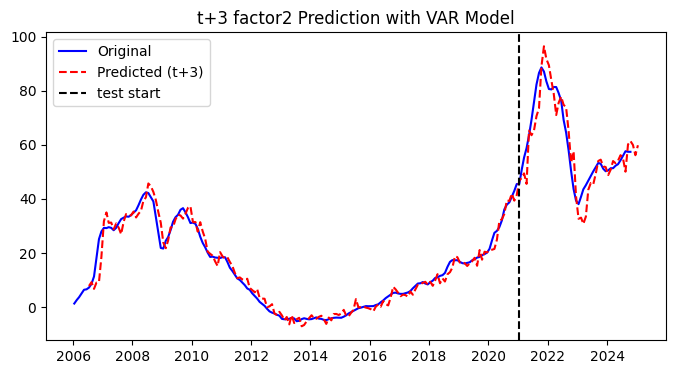

In [5]:
forecast_dfs = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    
    forecast_dfs[factor_name] = var_forecast(df, factor_name, TEST_DATE, MAXLAG_FACTOR, SELECTED_LAG_FACTOR, FORECAST_HORIZON)
    
    plot_var_forecast(df, forecast_dfs[factor_name], factor_name, TEST_DATE, FORECAST_HORIZON)

### Kalman Filter

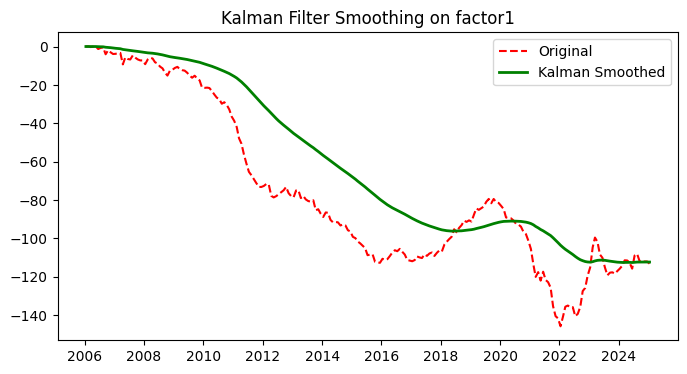

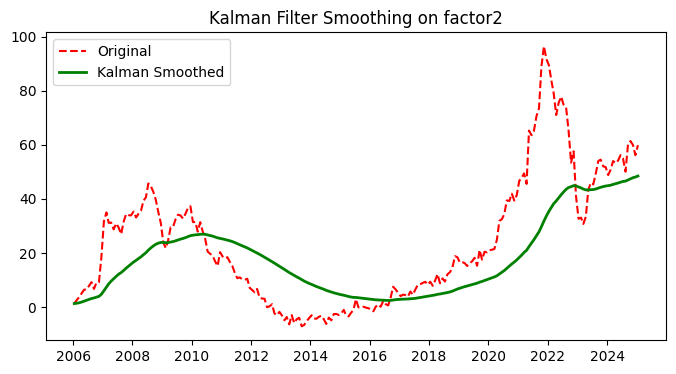

In [6]:
smoothed_factors = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    combined_series = pd.concat([df[factor_name][TRAIN_DATE:TRAIN_DATE[:6]+str(FORECAST_HORIZON+SELECTED_LAG_FACTOR)+'-15'], forecast_dfs[factor_name][factor_name]])
    smoothed = apply_kalman_filter(combined_series, KALMAN_OBSERVATION_COV, KALMAN_TRANSITION_COV)
    plot_kalman_filter_result(combined_series, smoothed, factor_name)
    smoothed_factors[factor_name] = smoothed


### Deep Residual Learning

In [7]:
smoothed_factors_df = pd.concat(list(smoothed_factors.values()), axis=1)
smoothed_factors_df.columns = [f"factor{i+1}" for i in range(optimal_factors)]

common_index = target_df.index.intersection(smoothed_factors_df.index)
smoothed_factors_df = smoothed_factors_df.loc[common_index]
target_df_common = target_df.loc[common_index]

target_mean = target_df_train.mean().values
factors_adjusted = (smoothed_factors_df.values @ loadings.T) * scale_factor + target_mean + offset

resid = target_df_common - factors_adjusted
resid = resid.reset_index().rename(columns={"index": "Date"})
resid["Date"] = pd.to_datetime(resid["Date"])

/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 41%|████▏     | 414/1000 [12:26<17:37,  1.80s/it]

Early stopping triggered.


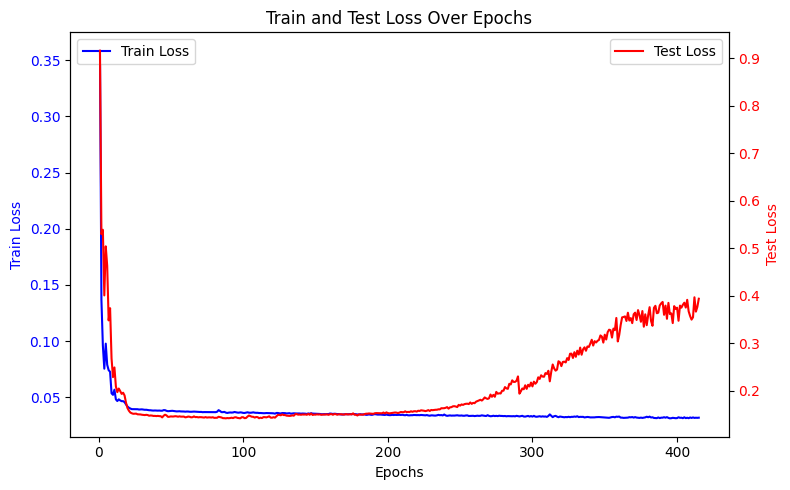

In [8]:
window_size  = WINDOW_SIZE
forecast_size = FORECAST_HORIZON
idx = resid[resid['Date'] == pd.to_datetime(TEST_DATE)].index[0]
train_df = resid.iloc[:idx]
test_df  = resid.iloc[idx - (forecast_size + window_size):].reset_index(drop=True)

columns_to_use = resid.columns.drop("Date")
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, "Date", columns_to_use)
train_x, train_y, train_date_list = time_slide_df(train_df_fe, window_size, forecast_size, "Date", columns_to_use)
test_x, test_y, test_date_list   = time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)

configs = Namespace(
    seq_len      = window_size,
    pred_len     = forecast_size,
    ker_len      = 25,
    enc_in       = len(columns_to_use),
    patch_len    = 3,
    stride       = 2,
    padding_patch= 'end',
    revin        = True,
    ma_type      = 'ema',
    alpha        = 0.3,
    beta         = 0.3,
    use_patch    = True,
    patch_size   = 3,
)
train_ds = Data(train_x, train_y)
test_ds  = Data(test_x, test_y)
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=len(test_df), shuffle=False)

model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
patience   = 20
save_path  = os.path.join(DIR_PATH, f"model{VERSION}.pth")

train_loss_list, test_loss_list = train_deep_learning_model(model, train_dl, test_dl, criterion, optimizer, num_epochs, patience, save_path)
plot_loss_curve(train_loss_list, test_loss_list)



### ✅ Deep Residual Learning Before & After Application

In [9]:
model.load_state_dict(torch.load(save_path))
model.eval()

train_outputs, train_targets = evaluate_model(model, DataLoader(train_ds, batch_size=len(train_ds), shuffle=False))
test_outputs, test_targets   = evaluate_model(model, DataLoader(test_ds, batch_size=len(test_ds), shuffle=False))

train_predicted = train_outputs[:, -1, :].cpu().numpy()
train_actual    = train_targets[:, -1, :].cpu().numpy()
train_dates = train_date_list[:, -1] 

test_predicted  = test_outputs[:, -1, :].cpu().numpy()
test_actual     = test_targets[:, -1, :].cpu().numpy()
test_dates = test_date_list[:, -1] 

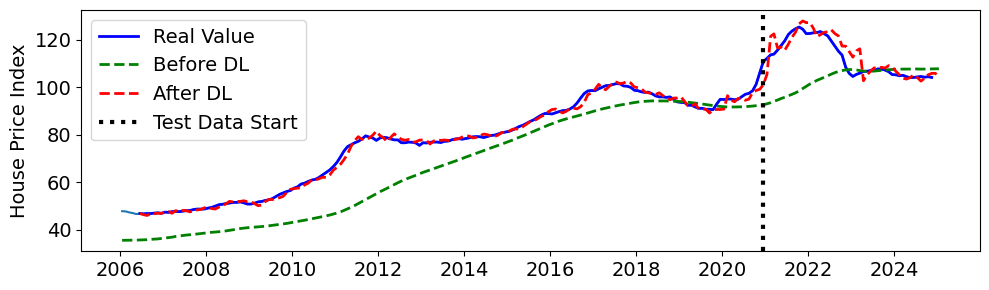

In [10]:
additional_test_x, additional_test_y, additional_test_date = test_time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)
addi_test_ds = Data(additional_test_x, additional_test_y)
addi_test_dl  = DataLoader(addi_test_ds, batch_size=len(additional_test_x), shuffle=False)
with torch.no_grad():
    for data, target in addi_test_dl:
        addi_test_output = model(data)
        addi_test_predicted = addi_test_output[:, -1, :].cpu().numpy() 

f = (pd.concat(smoothed_factors,axis=1).values @ loadings.T) * scale_factor + target_df_train.mean().values + offset
f_pd_all = pd.DataFrame(f, index=pd.to_datetime(smoothed_factors['factor1'].index), columns=target_df.columns)

plt.figure(figsize=(10, 3))
i = 1 # Busan
idv_mean = mean_[columns_to_use[i]]
idv_std = std_[columns_to_use[i]]

act = np.concatenate((train_actual[:, i], test_actual[:,i])) *idv_std+idv_mean
pre = np.concatenate((train_predicted[:, i], test_predicted[:,i],addi_test_predicted[:,i])) *idv_std+idv_mean 
dat = np.concatenate((train_dates,test_dates))

last_date = np.concatenate((train_dates,test_dates))[-1]
new_dat = np.array(pd.date_range(start=last_date, periods=forecast_size, freq="MS") + pd.DateOffset(days=14))

f_pd = pd.DataFrame(f_pd_all.iloc[:,i].values,index=f_pd_all.iloc[:,i].index)
act_pd = pd.DataFrame(act, index = pd.to_datetime(dat))
pre_pd = pd.DataFrame(pre, index = pd.to_datetime(np.concatenate((dat,new_dat))))

plt.plot(pd.to_datetime(target_df.index),target_df[target_df.columns[i]])
plt.plot(act_pd.add(f_pd).index, act_pd.add(f_pd),c='b',label="Real Value", linewidth=2)
plt.plot(f_pd.index, f_pd,c='green',label="Before DL", linestyle='--', linewidth=2)
plt.plot(pre_pd.add(f_pd).index, pre_pd.add(f_pd),c='r',label="After DL", linestyle='--', linewidth=2)
plt.plot()
plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3, label="Test Data Start")

plt.ylabel('House Price Index', fontsize=14)
plt.legend(loc="upper left", fontsize=14, frameon=True)
plt.tick_params(labelsize=14)

# pdf_path = "/Users/yeojisu/Desktop/HPI 예측/Ablation/DL.pdf"
# plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()